## Languages of the countries of the world

Welcome to this notebook, where we will be analyzing the diversity of languages in the countries of the world. We will be working with a dataset accessed through wikipedia, originating from ethnologue (https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country). This dataset will be combined with a dataset containing more general country statistics accessed through Kaggle https://www.kaggle.com/datasets/fernandol/countries-of-the-world.

The data will be analyzed with the aim of elaboration on the following questions:


- In which countries are the most respectivelt least languages spoken?
- Where are the most respectively least linguisticly divers countries of the world located?
- How does linguistic diversity distribute itself over the regions of the world?
- How well does the number of languages in a country correlate with lingusitic diversity?
- How is linguistic diversity influenced by the proportion of immigrant to established languages in a country?
- Which country variables can best predict linguistic diversity, if any at all?


Lets start by importing our four riders of the apocalypse:

In [476]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

Now we proceed with installing our datasets

In [477]:
Tables = pd.read_html('https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country')

As there are multiple tables on the website, we will import them all and have to select the one that we are looking for:

In [478]:
len(Tables)

3

In [479]:
print(Tables[0], Tables[1], Tables[2])


      0     1     2
0   Feb   APR   Sep
1   NaN    28   NaN
2  2017  2019  2020                Country Living languages                                \
               Country            Count Percent Established Immigrant   
0          Afghanistan               42    0.59          41         1   
1        Aland Islands                3    0.04           3         0   
2              Albania               12    0.17           8         4   
3              Algeria               22    0.31          18         4   
4       American Samoa                7    0.10           2         5   
..                 ...              ...     ...         ...       ...   
237  Wallis and Futuna                3    0.04           3         0   
238     Western Sahara                4    0.06           3         1   
239              Yemen               17    0.24          11         6   
240             Zambia               55    0.77          46         9   
241           Zimbabwe               24    0

We see that the second table contains the values for countries, languages and diversty, so lets go ahead and save it away as our dataframe and have a first look.

In [480]:
lingo = Tables[1]

In [481]:
lingo.head()

Country Living languages                                \
          Country            Count Percent Established Immigrant   
0     Afghanistan               42    0.59          41         1   
1   Aland Islands                3    0.04           3         0   
2         Albania               12    0.17           8         4   
3         Algeria               22    0.31          18         4   
4  American Samoa                7    0.10           2         5   

  Number of speakers                 Diversity           
               Total     Mean Median     Index Coverage  
0           23352300   569568  16500     0.796      98%  
1              27652     9217   1450     0.100     100%  
2            2847936   284794   9820     0.518      83%  
3           38548160  1927408  40000     0.511      91%  
4              56090     9348  25890     0.215      86%

In [482]:
lingo.shape

(242, 10)

In [483]:
print(lingo.columns)

lingo.columns.values

MultiIndex([(           'Country',     'Country'),
            (  'Living languages',       'Count'),
            (  'Living languages',     'Percent'),
            (  'Living languages', 'Established'),
            (  'Living languages',   'Immigrant'),
            ('Number of speakers',       'Total'),
            ('Number of speakers',        'Mean'),
            ('Number of speakers',      'Median'),
            (         'Diversity',       'Index'),
            (         'Diversity',    'Coverage')],
           )


array([('Country', 'Country'), ('Living languages', 'Count'),
       ('Living languages', 'Percent'),
       ('Living languages', 'Established'),
       ('Living languages', 'Immigrant'), ('Number of speakers', 'Total'),
       ('Number of speakers', 'Mean'), ('Number of speakers', 'Median'),
       ('Diversity', 'Index'), ('Diversity', 'Coverage')], dtype=object)

So, all in all we have 242 rows and 10 columns. Now, looking at the columns, we see that the dataframe is MultiIndex, which means that each column contains a dataframe with columns. This is something we would rather avoid, and as such we turn it into a single index dataframe.

In [484]:
new_columns_names = ['country', 'lang_count', 'lang_count(%)', 'lang_count_established', 'lang_count_immigrant', 'nmb_of_speakers_total', 'nmb_of_speakers_mean', 'nmb_of_speakers_median', 'diversity_index', 'diversity_coverage']

lingo.columns = new_columns_names

Before moving on, lets give a brief overview of the columns in the dataset:

- Country: Name of the country being studied.

- lang_count: The number of languages found in a given country

- lang_count(%): Percentage of the worlds languages that are found in a given country

- lang_count_established/immigrant: These two columns signal how many of the languages in a given country are established, having been in the country for a long time, and immigrant, being recently introduced through immigration.

- nmb_of_speakers_total/mean/median: These three columns gives the total meand and median number of speakers of any language in a given country

- diveristy_index: Contains the diversity index of a given country, by its Greenberg's diversity index, which is the probability of two random speakers in a given country speak different languages as mother language.

- diversity_coverage: Gives the percentage of the population for which estimates of number of speakers are given. A higher values thus means that the diversity index is calculated based on more complete data


Lets now get a some more info on how the dataset actually looks.

In [485]:
lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         242 non-null    object 
 9   diversity_coverage      242 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 19.0+ KB


We see that there are no null values, but diversity index and coverege are non_numeric, which they should be. So lets first make them numeric

In [486]:
lingo['diversity_index'] = pd.to_numeric(lingo['diversity_index'], errors='coerce')

lingo.diversity_coverage = lingo.diversity_coverage.replace("%", "", regex=True)
lingo['diversity_coverage'] = pd.to_numeric(lingo['diversity_coverage'], errors='coerce')

lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         239 non-null    float64
 9   diversity_coverage      242 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 19.0+ KB


We see that some missing values appeared in the diversity index when converting the data to numeric. We will go ahead and fill it in with the average value of the column

In [487]:
lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_84013/1211858122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()


Now what we will go ahead and do is to import our other datatable with the country statistic and merge it with our current language dataframe

In [488]:
Country_stats = pd.read_csv('countries of the world.csv')

In [489]:

Country_stats.head

<bound method NDFrame.head of              Country                               Region  Population  \
0       Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1           Albania   EASTERN EUROPE                          3581655   
2           Algeria   NORTHERN AFRICA                        32930091   
3    American Samoa   OCEANIA                                   57794   
4           Andorra   WESTERN EUROPE                            71201   
..               ...                                  ...         ...   
222       West Bank   NEAR EAST                               2460492   
223  Western Sahara   NORTHERN AFRICA                          273008   
224           Yemen   NEAR EAST                              21456188   
225          Zambia   SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe   SUB-SAHARAN AFRICA                     12236805   

     Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0            6

In [490]:
Country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

We see that there are some missing values for the dataframe, what we will do is to fill them in with the average of the column they are in and turn any stringrepresentations of numeric values into numerics.

In [491]:
Country_stats.replace(',', '.', regex=True, inplace=True)
for col in Country_stats.columns[2:]:
    Country_stats[col] = pd.to_numeric(Country_stats[col], errors='coerce')
    Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
    print(Country_stats[col])

0      31056997
1       3581655
2      32930091
3         57794
4         71201
         ...   
222     2460492
223      273008
224    21456188
225    11502010
226    12236805
Name: Population, Length: 227, dtype: int64
0       647500
1        28748
2      2381740
3          199
4          468
        ...   
222       5860
223     266000
224     527970
225     752614
226     390580
Name: Area (sq. mi.), Length: 227, dtype: int64
0       48.0
1      124.6
2       13.8
3      290.4
4      152.1
       ...  
222    419.9
223      1.0
224     40.6
225     15.3
226     31.3
Name: Pop. Density (per sq. mi.), Length: 227, dtype: float64
0       0.00
1       1.26
2       0.04
3      58.29
4       0.00
       ...  
222     0.00
223     0.42
224     0.36
225     0.00
226     0.00
Name: Coastline (coast/area ratio), Length: 227, dtype: float64
0      23.060000
1      -4.930000
2      -0.390000
3     -20.710000
4       6.600000
         ...    
222     2.980000
223     0.038125
224     0.000000
22

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_84013/2454244658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_84013/2454244658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_84013/2454244658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [492]:
Country_stats
#Country_stats.info()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.060000,163.070000,700.000000,36.000000,3.200000,12.13,0.22,87.65,1.0,46.600000,20.340000,0.380000,0.240000,0.380000
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.930000,21.520000,4500.000000,86.500000,71.200000,21.09,4.42,74.49,3.0,15.110000,5.220000,0.232000,0.188000,0.579000
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.390000,31.000000,6000.000000,70.000000,78.100000,3.22,0.25,96.53,1.0,17.140000,4.610000,0.101000,0.600000,0.298000
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.710000,9.270000,8000.000000,97.000000,259.500000,10.00,15.00,75.00,2.0,22.460000,3.270000,0.150844,0.282711,0.565283
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.600000,4.050000,19000.000000,100.000000,497.200000,2.22,0.00,97.78,3.0,8.710000,6.250000,0.150844,0.282711,0.565283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.9,0.00,2.980000,19.620000,800.000000,82.838278,145.200000,16.90,18.97,64.13,3.0,31.670000,3.920000,0.090000,0.280000,0.630000
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.0,0.42,0.038125,35.506964,9689.823009,82.838278,236.061435,0.02,0.00,99.98,1.0,22.114732,9.241345,0.150844,0.282711,0.400000
224,Yemen,NEAR EAST,21456188,527970,40.6,0.36,0.000000,61.500000,800.000000,50.200000,37.200000,2.78,0.24,96.98,1.0,42.890000,8.300000,0.135000,0.472000,0.393000
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.3,0.00,0.000000,88.290000,800.000000,80.600000,8.200000,7.08,0.03,92.90,2.0,41.000000,19.930000,0.220000,0.290000,0.489000


Perfect, now we can go ahead and merge the dataframes. The key value that we want to index on, the name of the country, has an ampty space as part of thes tring after the name in our Countr_stats dataset. We therefore have to remove this so that the columns are indentical. Furthermore, our linguistic diversity dataset has more rows, signalling it has included more places than just countries, such as autonomous regions. We will therefore do an innerjoin, making sure that only the countries present in both dataset is part of the final dataset.

In [493]:
i = 0
for x in Country_stats.Country:
    Country_stats.loc[i,'Country'] = Country_stats.loc[i,'Country'][0:-1]
    i +=1

Country_stats.rename(columns={'Country':'country'}, inplace=True)
df = pd.merge(lingo, Country_stats, on='country', how = 'inner')

Okay, now we have our final data set. Lets do a quick inspection and then proceed with some plots :)

In [494]:
df.head(10)

,country,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage,...,Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,42,0.59,41,1,23352300,569568,16500,0.796,98,...,3.2,12.13,0.22,87.65,1.000000,46.60,20.34,0.380000,0.240000,0.380000
1,Albania,12,0.17,8,4,2847936,284794,9820,0.518,83,...,71.2,21.09,4.42,74.49,3.000000,15.11,5.22,0.232000,0.188000,0.579000
2,Algeria,22,0.31,18,4,38548160,1927408,40000,0.511,91,...,78.1,3.22,0.25,96.53,1.000000,17.14,4.61,0.101000,0.600000,0.298000
3,American Samoa,7,0.10,2,5,56090,9348,25890,0.215,86,...,259.5,10.00,15.00,75.00,2.000000,22.46,3.27,0.150844,0.282711,0.565283
4,Andorra,5,0.07,4,1,73500,18375,19650,0.664,80,...,497.2,2.22,0.00,97.78,3.000000,8.71,6.25,0.150844,0.282711,0.565283
5,Angola,47,0.66,46,1,24288770,528017,30000,0.745,98,...,7.8,2.41,0.24,97.35,2.139024,45.11,24.20,0.096000,0.658000,0.246000
6,Anguilla,2,0.03,2,0,12450,6225,6225,0.141,100,...,460.0,0.00,0.00,100.00,2.000000,14.17,5.34,0.040000,0.180000,0.780000
7,Argentina,40,0.56,24,16,46160150,1318861,5120,0.155,88,...,220.4,12.31,0.48,87.21,3.000000,16.73,7.55,0.095000,0.358000,0.547000
8,Armenia,14,0.20,8,6,3036180,276016,8850,0.049,79,...,195.7,17.55,2.30,80.15,4.000000,12.07,8.23,0.239000,0.343000,0.418000
9,Aruba,6,0.08,4,2,86790,21698,7000,0.484,67,...,516.1,10.53,0.00,89.47,2.000000,11.03,6.68,0.004000,0.333000,0.663000


In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             195 non-null    object 
 1   lang_count                          195 non-null    int64  
 2   lang_count(%)                       195 non-null    float64
 3   lang_count_established              195 non-null    int64  
 4   lang_count_immigrant                195 non-null    int64  
 5   nmb_of_speakers_total               195 non-null    int64  
 6   nmb_of_speakers_mean                195 non-null    int64  
 7   nmb_of_speakers_median              195 non-null    int64  
 8   diversity_index                     195 non-null    float64
 9   diversity_coverage                  195 non-null    int64  
 10  Region                              195 non-null    object 
 11  Population                          195 non-n

In [496]:
df.describe()

,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage,Population,...,Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,1.950000e+02,1.950000e+02,1.950000e+02,195.000000,195.000000,1.950000e+02,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,50.856410,0.715641,42.082051,8.774359,3.340699e+07,5.989039e+05,1.063905e+05,0.432547,87.143590,3.094257e+07,...,229.089465,13.913304,4.274454,81.811829,2.116823,22.245868,9.340489,0.152001,0.287678,0.559002
std,103.455304,1.454643,100.945343,15.918943,1.348912e+08,1.011439e+06,4.355498e+05,0.295990,12.740466,1.264939e+08,...,226.530391,13.536695,7.561469,16.290000,0.685736,11.112827,4.873322,0.138471,0.131867,0.155047
min,1.000000,0.010000,1.000000,0.000000,3.920000e+03,1.722000e+03,1.000000e+01,0.000000,50.000000,7.502000e+03,...,1.300000,0.000000,0.000000,33.330000,1.000000,8.250000,2.410000,0.000000,0.020000,0.062000
25%,9.000000,0.130000,4.000000,1.000000,6.117500e+05,6.396600e+04,6.975000e+03,0.158000,80.000000,5.133195e+05,...,38.500000,3.020000,0.190000,70.465000,2.000000,12.635000,6.130000,0.041500,0.204000,0.443500
50%,23.000000,0.320000,13.000000,4.000000,6.322800e+06,2.847940e+05,2.310000e+04,0.443000,91.000000,5.548702e+06,...,153.800000,10.380000,1.030000,86.950000,2.000000,20.340000,8.230000,0.117000,0.282711,0.565283
75%,45.000000,0.630000,30.500000,8.000000,1.873582e+07,6.168810e+05,6.605000e+04,0.702500,98.000000,1.796809e+07,...,338.500000,21.025000,4.502111,95.675000,2.319512,29.770000,10.560000,0.214500,0.335000,0.665500
max,840.000000,11.810000,840.000000,116.000000,1.319419e+09,8.627658e+06,5.700000e+06,0.988000,100.000000,1.313974e+09,...,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.500000,0.769000,0.906000,0.954000



Now we have merged our datasets, cleaned the data and have gotten a very rough idea of what our data looks like

Lets continue by getting diving into our most important variables, beginning with linguistic diversity.

In [ ]:
df.lang_count.plot(figsize = (10,8)),
        kind = 'box'

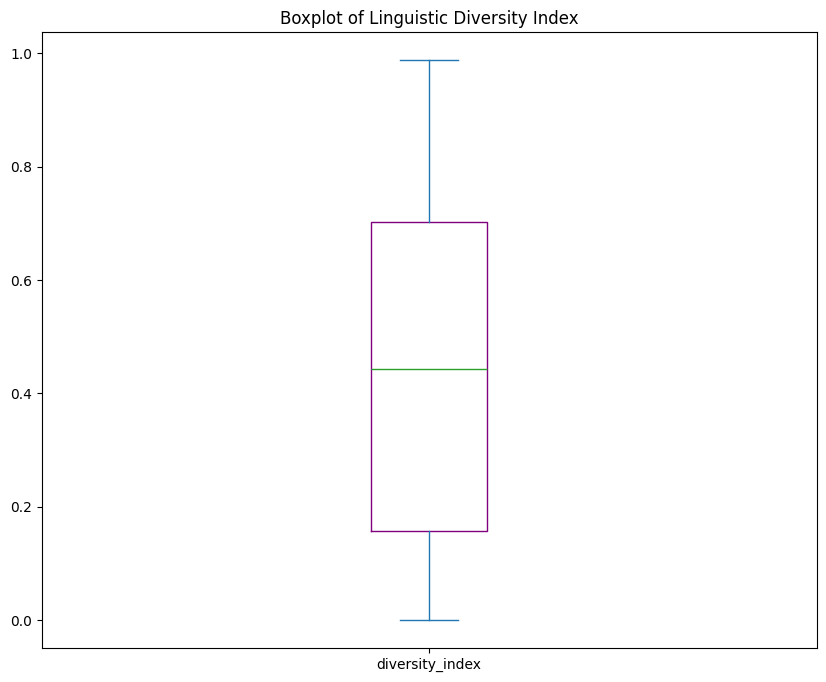

In [520]:
df.diversity_index.plot(figsize=(10,8),
    kind = 'box',
    title = 'Boxplot of Linguistic Diversity Index',
    color=dict(boxes='Purple')
    );



The Boxplot for the linguistic diversity index is very neat, showing a median at a little below 0.5 and a very evenly distributed quartiles. One can notice a right tail skew however. Lets go ahead and also look at its histogram

<Axes: ylabel='Frequency'>

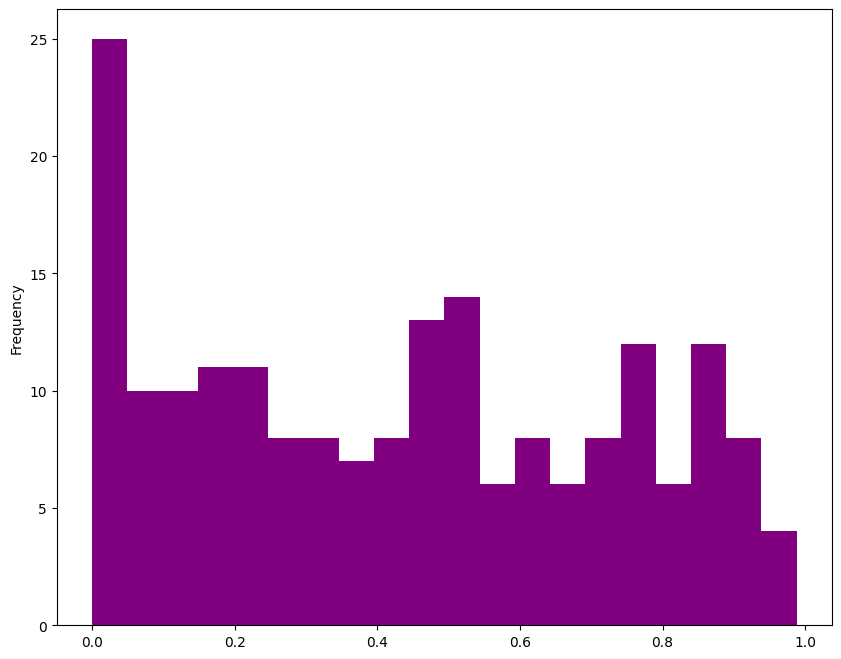

In [524]:
df.diversity_index.plot(figsize = (10,8),
        kind = 'hist',
        color = 'purple', 
        bins = 20       
);